In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('csv/GoogleStockPrices.csv',parse_dates = [0] )

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.describe().round(2)

,Date,Open,High,Low,Close,Volume
count,2516,2516.00,2516.00,2516.00,2516.00,2.516000e+03
mean,2020-01-01 11:02:23.799682048,82.68,83.56,81.83,82.71,8.797572e+06
min,2015-01-02 16:00:00,24.96,25.01,24.55,24.85,4.656380e+05
25%,2017-07-02 22:00:00,47.37,47.64,47.00,47.38,1.398751e+06
50%,2020-01-01 16:00:00,64.53,65.04,63.94,64.71,1.876044e+06
75%,2022-06-30 22:00:00,119.66,121.04,118.59,119.70,6.056782e+06
max,2024-12-31 16:00:00,197.25,201.42,194.98,196.66,1.194550e+08
std,NaN,43.72,44.21,43.26,43.74,1.365305e+07


In [5]:
dias_que_subiu = (df['Close'] > df['Close'].shift(1)).sum()
print(f'O preço subiu em {dias_que_subiu} dias.')

O preço subiu em 1345 dias.


#### Gráfico do preço de fechamento: 

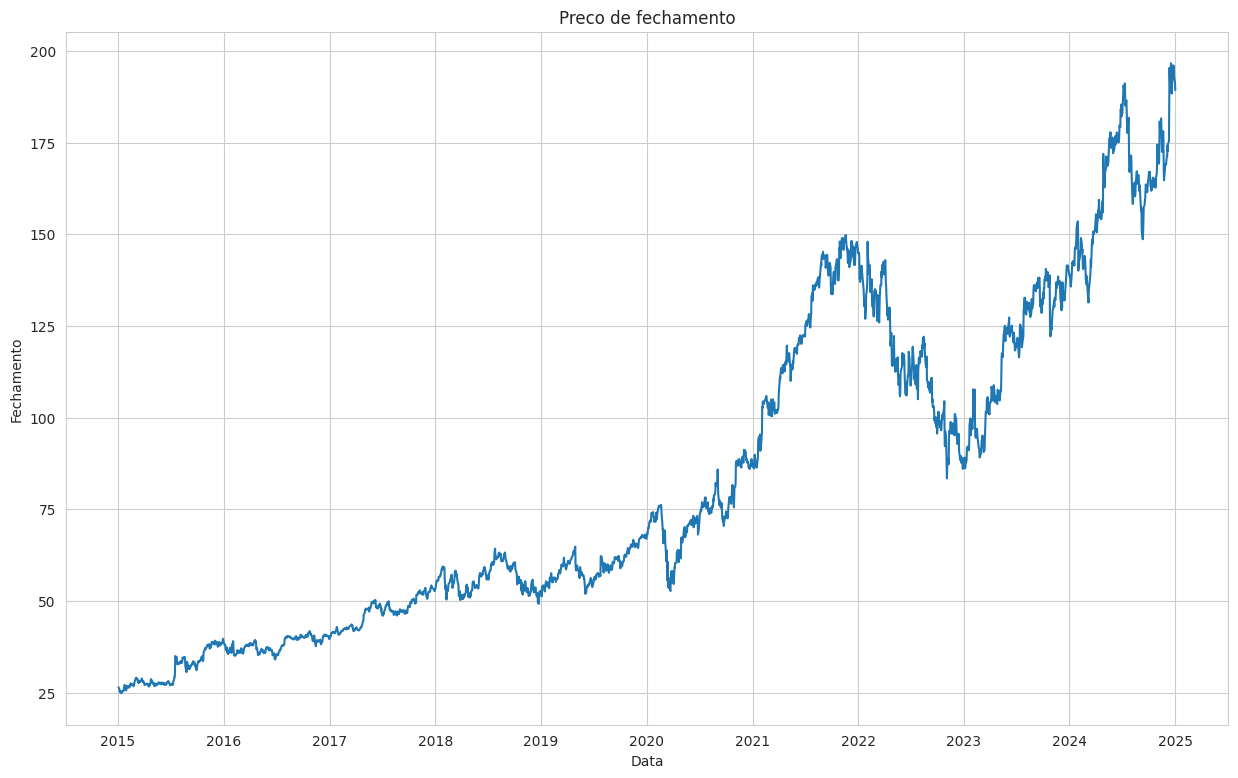

In [6]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize = (15,9))
    grafico = sns.lineplot(data = df, x = 'Date',y = 'Close')
    grafico.set(title = 'Preco de fechamento', xlabel = 'Data', ylabel = 'Fechamento')


#### Grafico de 2024:


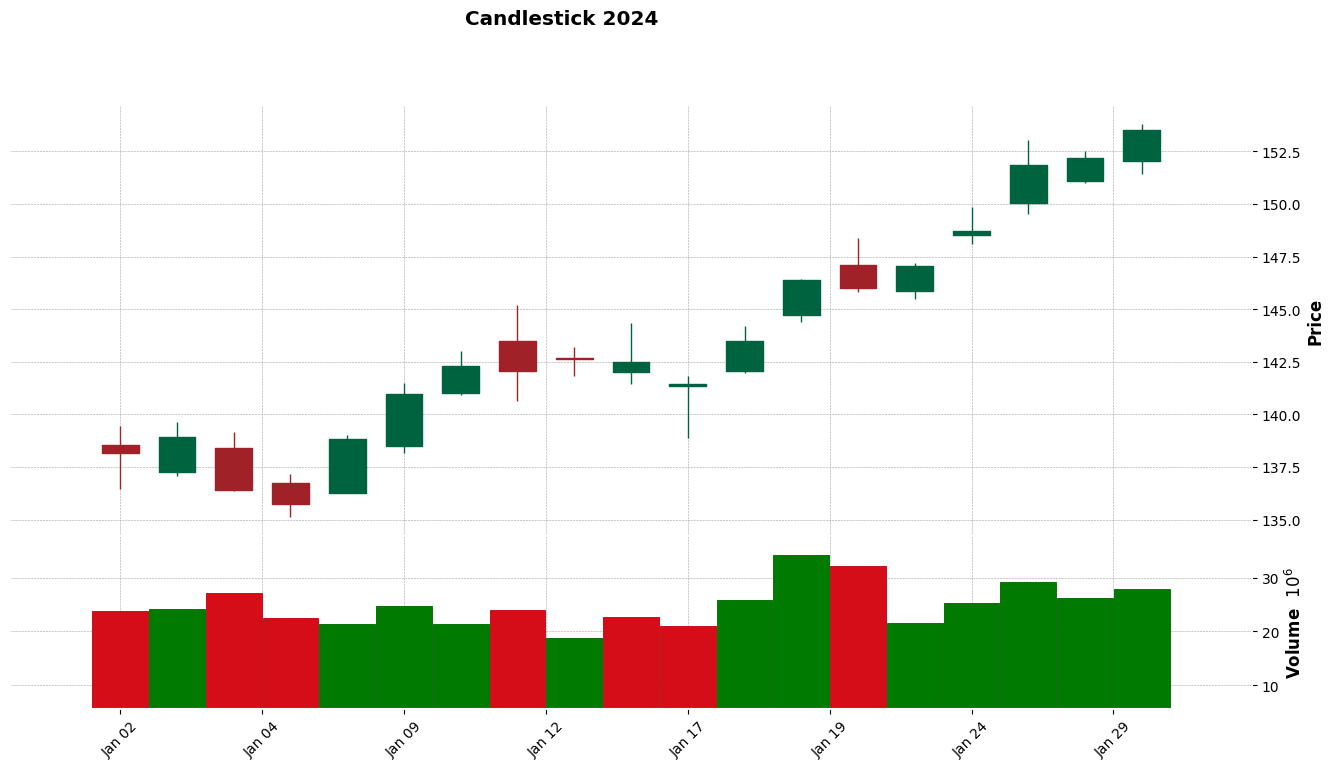

In [7]:

df['Date'] = pd.to_datetime(df['Date'])


df_2024 = df.query('Date >= "2024-01-01" and Date <= "2024-01-30"').copy()

df_2024.set_index('Date', inplace=True)

mpf.plot(df_2024, type='candle', style='charles', title='Candlestick 2024', volume=True,figratio=(20, 10),figscale=1.5 )



In [8]:
volume_2015 = df.query('Date >= "2015-01-01"and Date <= "2015-12-31"').copy()
volume_2015_media = volume_2015['Volume'].mean()
volume_2024 = df.query('Date >= "2024-01-01"and Date <= "2024-12-31"').copy()
volume_2024_media = volume_2024['Volume'].mean()


In [9]:
diferenca_volume = (volume_2024_media - volume_2015_media)
print(f'Volume médio em 2015: {volume_2015_media:,.0f}')
print(f'Volume médio em 2024: {volume_2024_media:,.0f}')
print(f'Diferença: {diferenca_volume:,.0f}')

Volume médio em 2015: 2,172,317
Volume médio em 2024: 27,500,206
Diferença: 25,327,889


#### Média móvel de 20 dias do preço de fechamento:

In [10]:
df['MM20'] = df['Close'].rolling(window=20).mean()

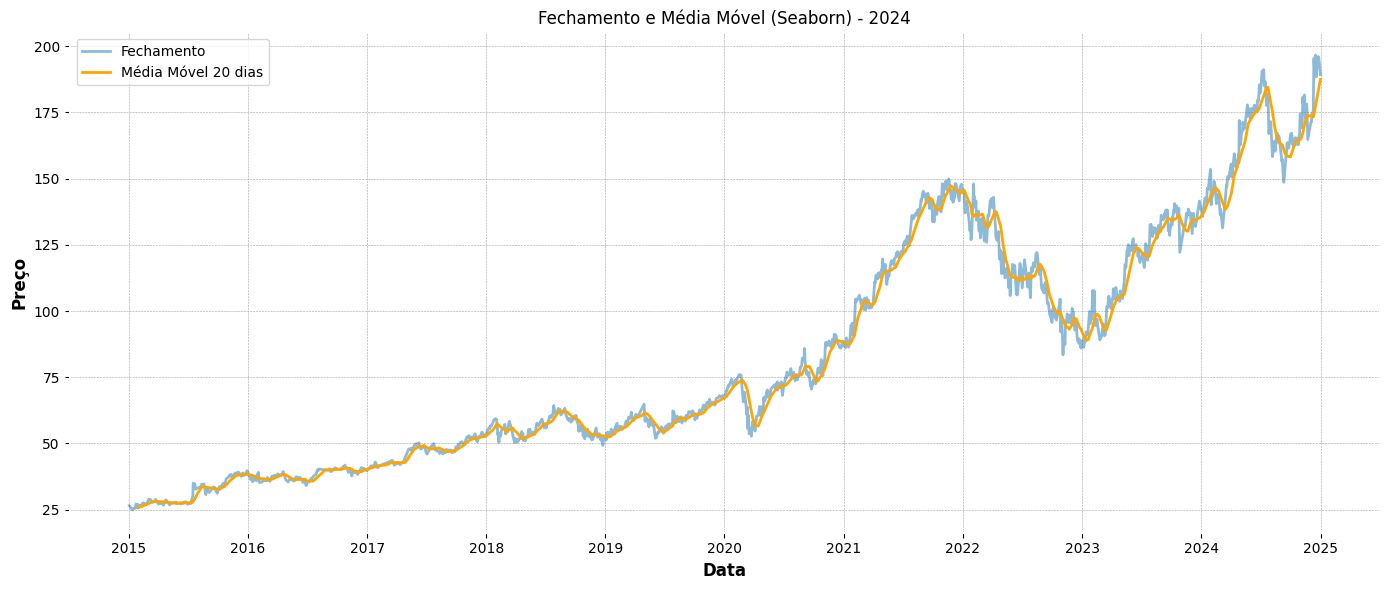

In [11]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Close', data=df, label='Fechamento', alpha=0.5)
sns.lineplot(x='Date', y='MM20', data=df, label='Média Móvel 20 dias', color='orange')
plt.title('Fechamento e Média Móvel (Seaborn) - 2024')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Distribuição Retorno Diário:

In [12]:
df['Retorno_Diario'] = df['Close'].pct_change()
df_limp = df.dropna(subset=['Retorno_Diario'])

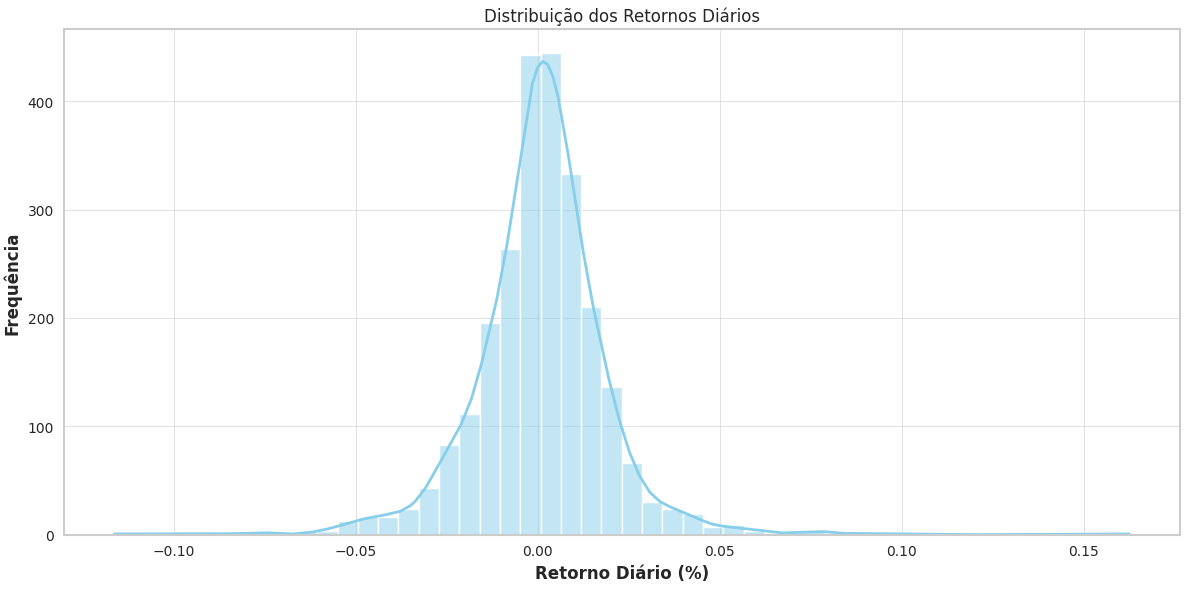

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12,6))
    grafico = sns.histplot(data = df_limp, x = 'Retorno_Diario', kde = True,bins = 50,color='skyblue')
    grafico.set(title = 'Distribuição dos Retornos Diários', xlabel = 'Retorno Diário (%)',ylabel = 'Frequência')
    plt.title('Distribuição dos Retornos Diários')
    plt.tight_layout()


#### RSI (Índice de Força Relativa) e identifique momentos de sobrecompra/sobrevenda:

In [14]:
df['variacao_Close'] = df['Close'].diff()

df['ganho'] = df['variacao_Close'].clip(lower = 0)
df['perda'] = -df['variacao_Close'].clip(upper = 0)
df['perda'] = df['perda'].abs()# Remove o sinal

ganhos_eme = df['ganho'].ewm(span = 14,adjust = False).mean() # span mostra de quantos em quantos dias a media vai ser tirada
perdas_eme = df['perda'].ewm(span = 14,adjust = False).mean()

rs = ganhos_eme / perdas_eme

df['RSI'] = 100 - (100 / (1 + rs)).round(2)

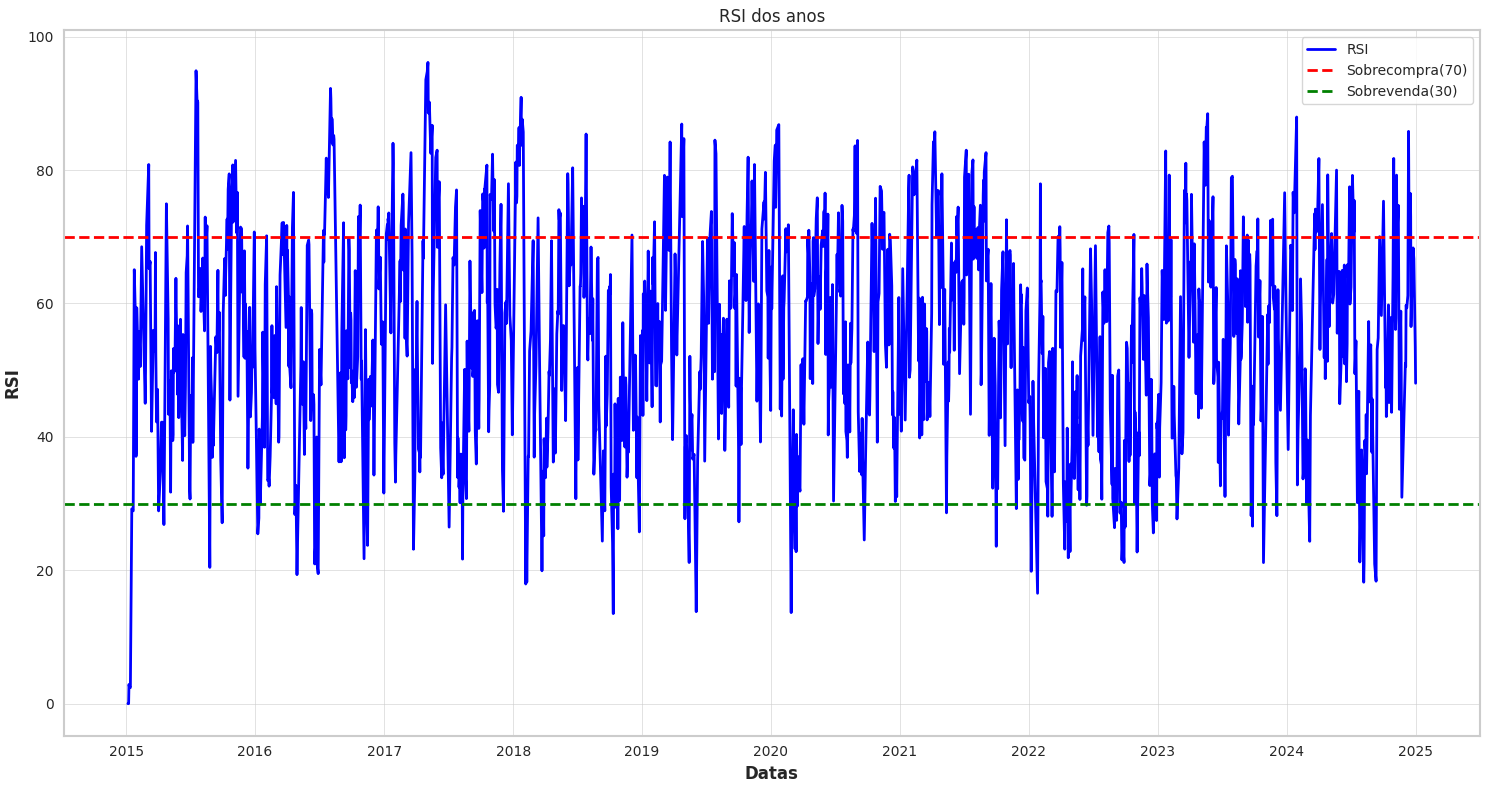

In [15]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize = (15,8))
    grafico = sns.lineplot(data = df, x = 'Date', y = 'RSI', color = 'blue', label = 'RSI')
    plt.axhline(70, color = 'red', linestyle = '--',label = 'Sobrecompra(70)')
    plt.axhline(30, color = 'green', linestyle = '--', label = 'Sobrevenda(30)')
    grafico.set(title = 'RSI dos anos', xlabel = 'Datas', ylabel = 'RSI')
    plt.tight_layout()
    plt.legend()

#### Sistema de cruzamento de médias móveis:

In [16]:
df['MM_curta'] = df['Close'].rolling(20).mean()
df['MM_longa'] = df['Close'].rolling(50).mean()

df['posicao'] = (df['MM_curta'] > df['MM_longa']).astype(int)

df['cruzou'] = df['posicao'].diff()

# interpretações:
# df['cruzou'] == +1  -> cruzamento de ALTA (compra)
# df['cruzou'] == -1  -> cruzamento de BAIXA (venda)


In [17]:

df['ret'] = df['Close'].pct_change()
df['posicao_shift'] = df['posicao'].shift(1)
df['ret_estrategia'] = df['posicao_shift'] * df['ret']

perf_buy_hold = (1 + df['ret']).cumprod()
perf_estrategia = (1 + df['ret_estrategia']).cumprod()

df['EMA_curta'] = df['Close'].ewm(span=20, adjust=False).mean().round(3)
df['EMA_longa'] = df['Close'].ewm(span=50, adjust=False).mean().round(3)

df['EMA_curta'] = df['Close'].ewm(span=20, adjust=False).mean().round(3)
df['EMA_longa'] = df['Close'].ewm(span=50, adjust=False).mean().round(3)

####  Maiores drawdowns:

In [18]:
df['Pico_Anterior'] = df['Close'].cummax()
df['Drawdown'] = (df['Close'] - df['Pico_Anterior']) / df['Pico_Anterior']

maiores_dd = df.nsmallest(5, 'Drawdown').round(3)
print(maiores_dd[['Date', 'Close', 'Pico_Anterior', 'Drawdown']])

                    Date  Close  Pico_Anterior  Drawdown
1974 2022-11-03 16:00:00  83.43         149.84    -0.443
2011 2022-12-28 16:00:00  86.02         149.84    -0.426
2016 2023-01-05 16:00:00  86.20         149.84    -0.425
1975 2022-11-04 16:00:00  86.58         149.84    -0.422
1973 2022-11-02 16:00:00  86.97         149.84    -0.420


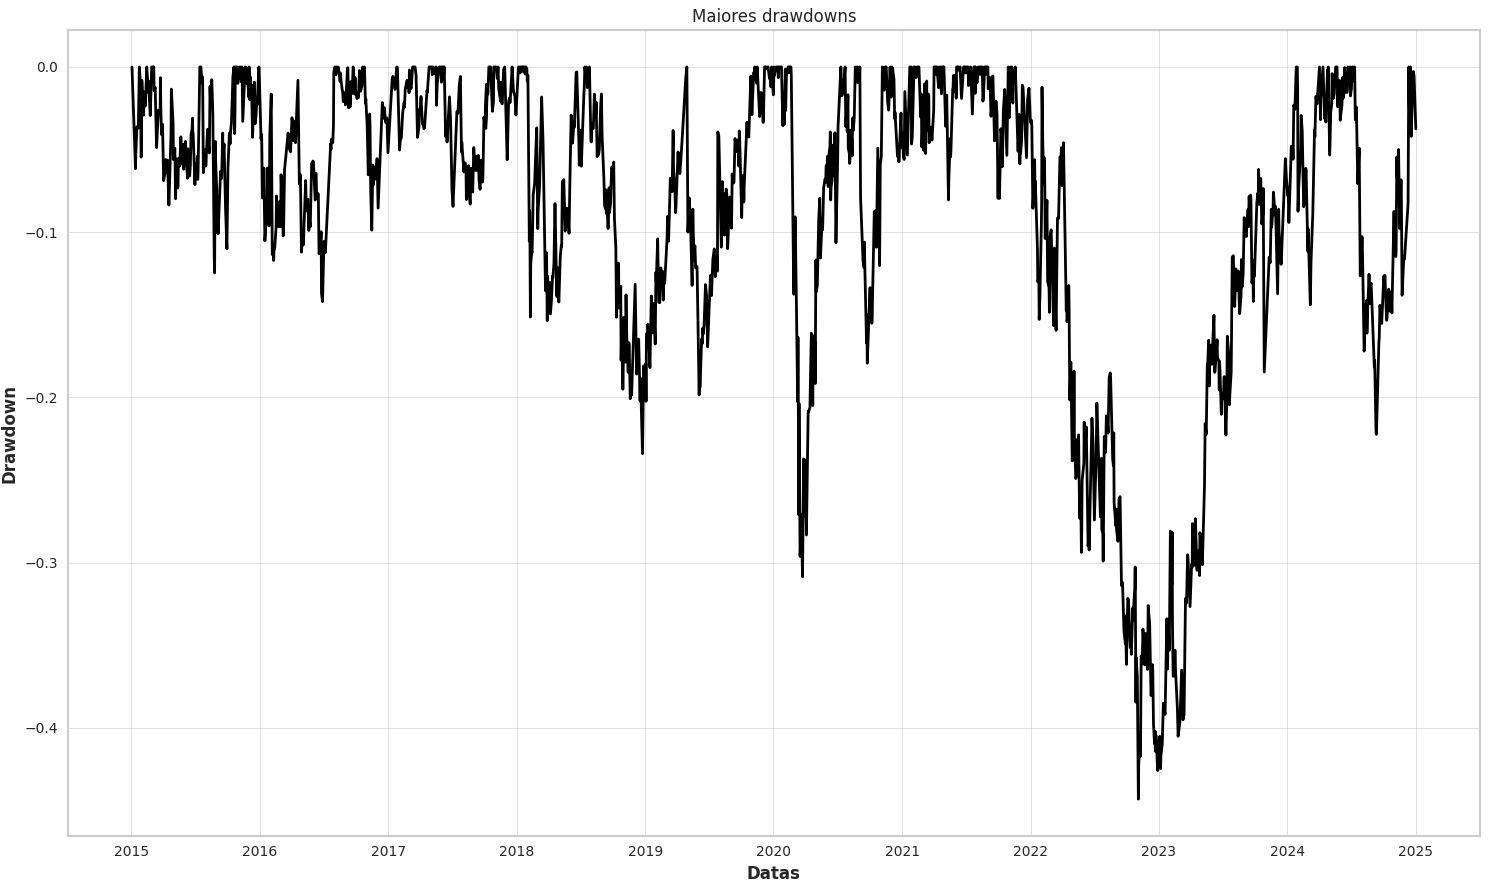

In [19]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize = (15,9))
    grafico = sns.lineplot(data = df, x = 'Date', y = 'Drawdown',color = 'black')
    grafico.set(title = 'Maiores drawdowns', xlabel = 'Datas', ylabel = 'Drawdown')
    plt.tight_layout()

#### Modelos ARIMA para prever o preço de fechamento nos próximos 10 dias:

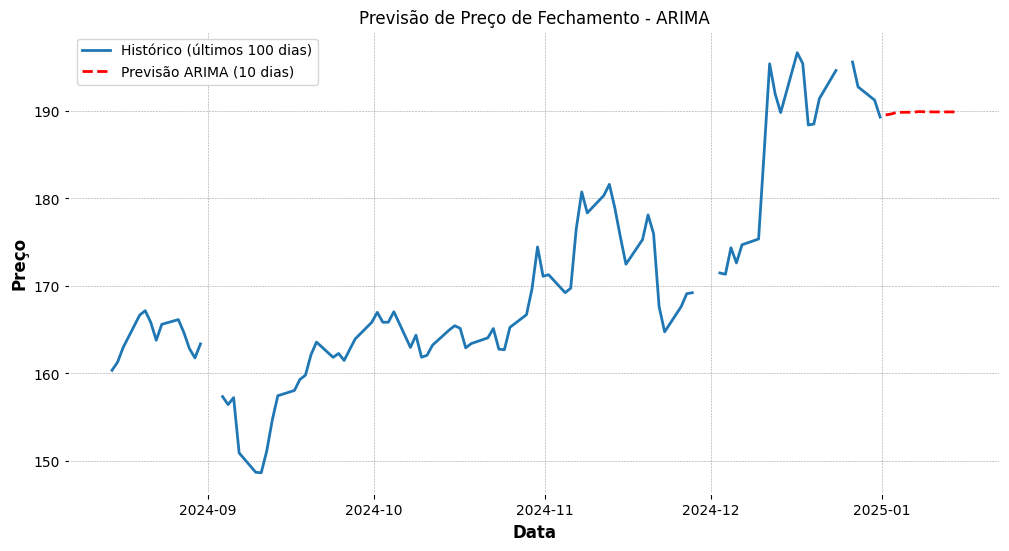

In [20]:
df_data = df.copy()
df_data.set_index('Date', inplace=True)

df_data = df_data.asfreq('B')

fechamento = df_data['Close']

modelo = ARIMA(fechamento, order=(5,1,0))
modelo_treinado = modelo.fit()

previsao = modelo_treinado.forecast(steps=10)

datas_previstas = pd.date_range(start=fechamento.index[-1] + pd.Timedelta(days=1), periods=10, freq='B')  # dias úteis
df_previsao = pd.DataFrame({'Close_Previsto': previsao}, index=datas_previstas)
df_data = df_data.asfreq('B')

plt.figure(figsize=(12,6))
plt.plot(fechamento[-100:], label='Histórico (últimos 100 dias)')
plt.plot(df_previsao, label='Previsão ARIMA (10 dias)', linestyle='--', color='red')
plt.title('Previsão de Preço de Fechamento - ARIMA')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()

#### Clusterize os dias de negociação"Volatilidade" e "Volume":

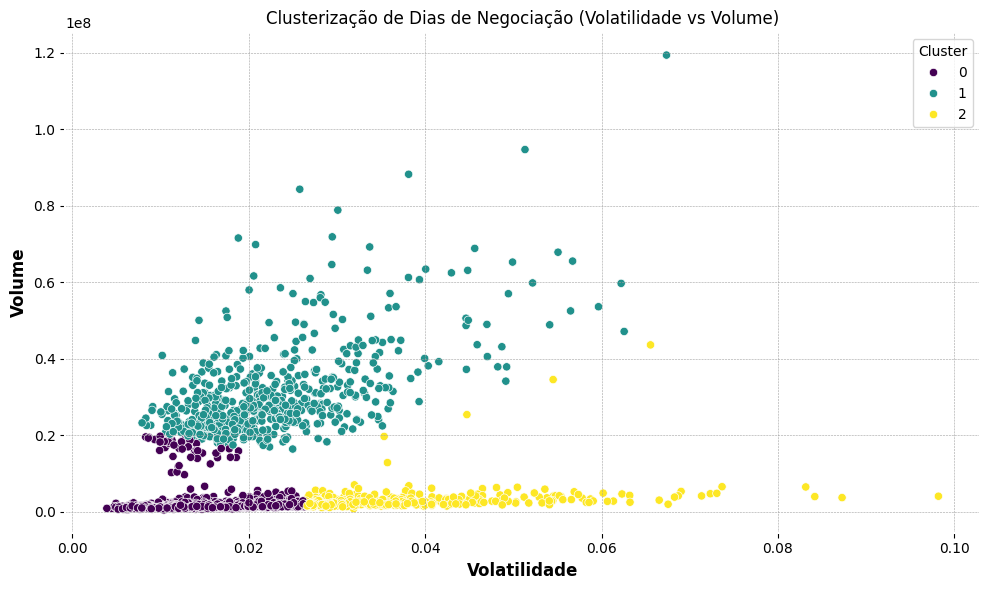

In [21]:
df_cluster = df[['High', 'Low', 'Close', 'Volume']].copy()


df_cluster['Volatilidade'] = (df_cluster['High'] - df_cluster['Low']) / df_cluster['Close']

df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)


features = df_cluster[['Volatilidade', 'Volume']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volatilidade', y='Volume', hue='Cluster',palette='viridis', data=df_cluster)
plt.title('Clusterização de Dias de Negociação (Volatilidade vs Volume)')
plt.xlabel('Volatilidade')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()




#### Lucro percentua 2015 a 2024:

In [22]:
low_2015 = df_data.loc['2015','Low'].min()

high_2024 = df_data.loc['2024','High'].max()

lucro_percentual = ((high_2024 - low_2015) / low_2015) * 100

print(f'Menor valor 2015: {low_2015:.2f}, Maior valor 2024: {high_2024:.2f}, Lucro percentual :{lucro_percentual:.2f}%')

Menor valor 2015: 24.55, Maior valor 2024: 201.42, Lucro percentual :720.45%


####  Desempenho médio dos anos :

In [23]:
df_mes = df.copy()
df_mes = df_mes.set_index('Date')
df_mes = df_mes.resample('1ME').mean()
mean_mes_fechamento = df_mes['Close'].groupby(df_mes.index).mean().round(2).reset_index()
mean_mes_abertura = df_mes['Open'].groupby(df_mes.index).mean().round(2).reset_index()

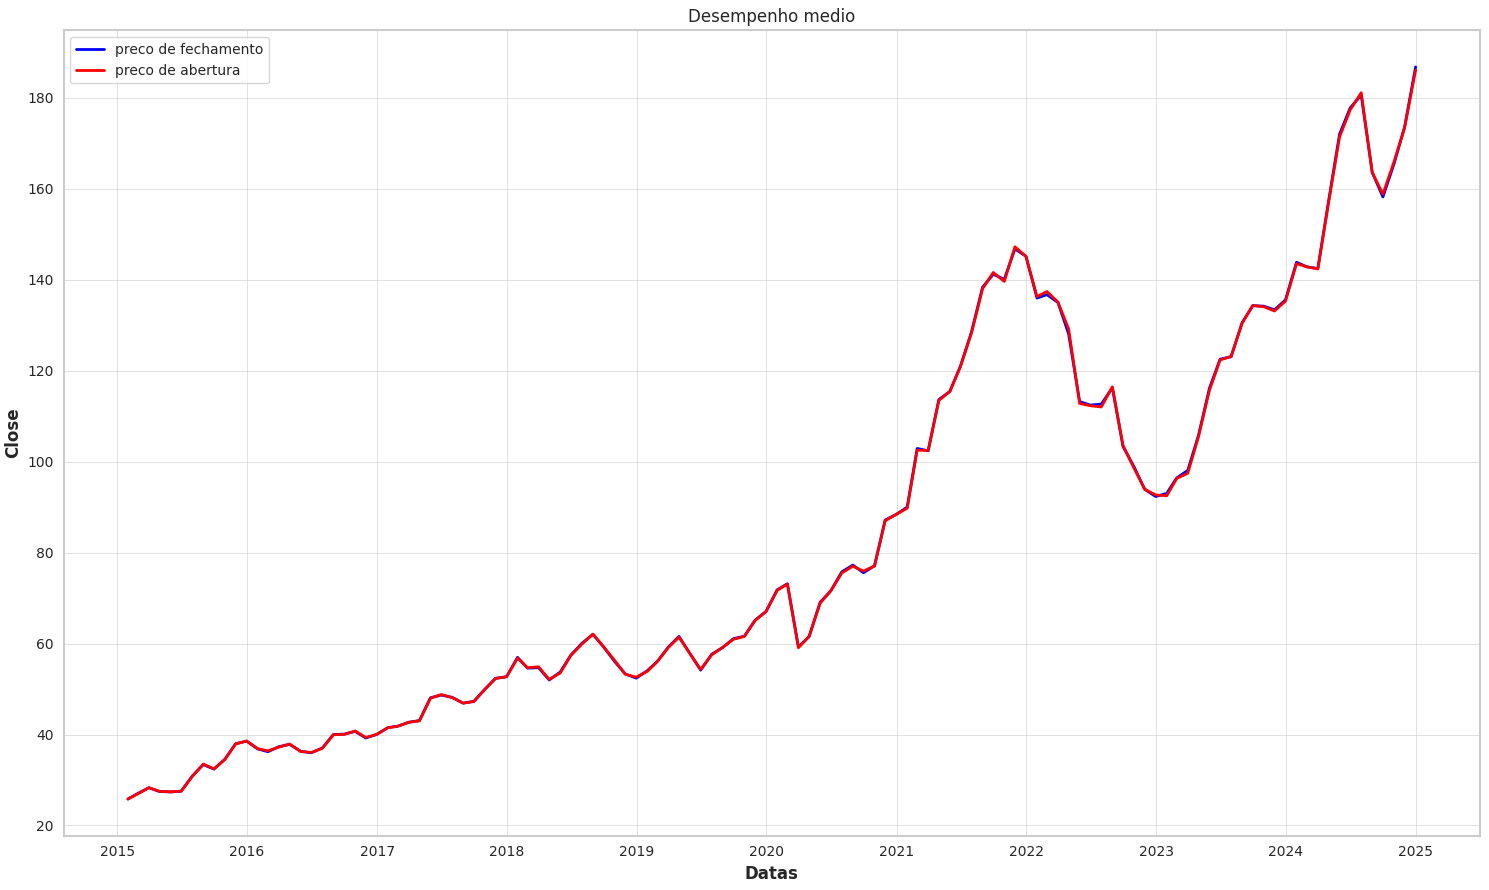

In [24]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15,9))
    grafico = sns.lineplot(data = mean_mes_fechamento, x = 'Date', y = 'Close', label = 'preco de fechamento', color = 'blue')
    grafico = sns.lineplot(data = mean_mes_abertura,x = 'Date', y = 'Open', label = 'preco de abertura', color = 'red')
    grafico.set(title = 'Desempenho medio',xlabel = 'Datas', ylabel = 'Close')
    plt.legend()
    plt.tight_layout()

#### Correlação do volume com a variação de preço diário:

In [25]:
df_correlacao = df.copy()
df_correlacao.dropna(inplace=True)
df_correlacao['medida'] = df_correlacao['High'] - df_correlacao['Low']

In [26]:
np.corrcoef(df_correlacao['Volume'],df_correlacao['medida'])

array([[1.        , 0.55629954],
       [0.55629954, 1.        ]])

In [27]:
np.corrcoef(df_correlacao['Volume'],df_correlacao['Retorno_Diario'])

array([[ 1.        , -0.00633254],
       [-0.00633254,  1.        ]])